In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from numpy.random import seed

sns.set_palette("muted")

In [2]:
df = pd.read_csv('proteins_dataframe_final.csv')
df = df.drop(6616)
df = df[df['loc'] != 'rough_er']

In [3]:
#Grouping datasets by localization for analysis
mitochondria = df.groupby('loc').get_group('mitochondria')
cytoplasm = df.groupby('loc').get_group('cytoplasm')
er = df.groupby('loc').get_group('endoplasmic_reticulum')
endosome = df.groupby('loc').get_group('endosome')
golgi = df.groupby('loc').get_group('golgi')
membrane = df.groupby('loc').get_group('membrane')
nucleus = df.groupby('loc').get_group('nucleus')
#rough_er = df.groupby('loc').get_group('rough_er')
vesicle = df.groupby('loc').get_group('vesicle')
cytoskeleton = df.groupby('loc').get_group('cytoskeleton')

localizations_str = ['mitochondria','cytoplasm','er','endosome','golgi','membrane','nucleus','vesicle']
localizations = [mitochondria,cytoskeleton, cytoplasm,er,endosome,golgi,membrane,nucleus, vesicle]

1. Are there variables that are particularly significant in terms of explaining the answer to your project question?
2. Are there significant differences between subgroups in your data that may be relevant to your project aim?
3. Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?
4. What are the most appropriate tests to use to analyze these relationships?

# Significant Variables to Subcellular Localization:

## Net Charge

The net charge of the protein was calculated by adding the number of positve amino acids to the number of negative amino acids in a peptide sequence. Peptide sequences with a higher than average net charge appear to localize to the nucleus, while low charge proteins localize to regions like endosomes and vesicles.

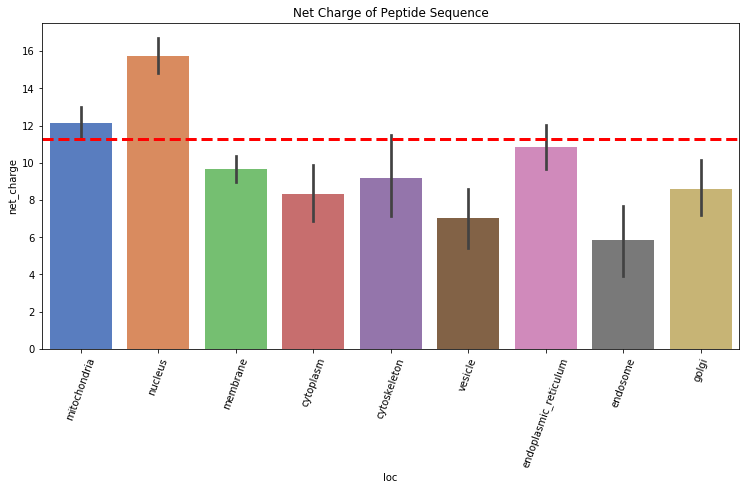

In [4]:
figsize(12.5,6)

_ = sns.barplot(x='loc', y='net_charge', data=df)
_ = plt.xticks(rotation=70)
_ = plt.axhline(y=np.mean(df.net_charge), color='red', linestyle='--', lw=3)
_ = plt.title('Net Charge of Peptide Sequence')

### Visualization of data to determine distribution

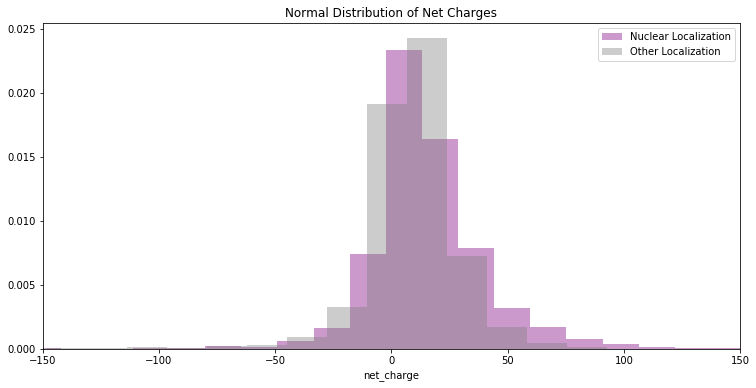

In [5]:
# To compare the nucleus associated proteins with the rest, a new subset of data is created containing all peptides not associated with the nucleus.
nuclear = df[df['loc'] == 'nucleus']
non_nuclear = df[df['loc'] != 'nucleus']

nuclear_charge = nuclear.net_charge
non_nuclear_charge = non_nuclear.net_charge

_ = sns.distplot(nuclear_charge, bins=50, kde=False, norm_hist=True, label='Nuclear Localization', color ='purple')
_ = sns.distplot(non_nuclear_charge, bins=50, kde=False, norm_hist=True, label='Other Localization', color ='gray')
_ = plt.xlim([-150,150])
_ = plt.legend()
_ = plt.title('Normal Distribution of Net Charges')

### Bootstrapping to determine if the observed difference is the net charge of nuclear proteins is statistically significant

In [6]:
# Bootstrapping Function
np.random.seed(47)
N_rep = 10000

# Credit to DataCamp 'Statistical Thinking in Python Part 2' module for function.

def bootstrap_replicate_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)

    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

In [7]:
# Means of nuclear and non-nuclear proteins are shifted to model the scenario where the mean net charge of a peptide is the same between groups.
observed_mean_difference = np.mean(nuclear_charge) - np.mean(non_nuclear_charge)
mean_charge = np.mean(np.concatenate((nuclear_charge,non_nuclear_charge)))
nuclear_shifted = nuclear_charge - np.mean(nuclear_charge) + mean_charge
non_nuclear_shifted = non_nuclear_charge - np.mean(non_nuclear_charge) + mean_charge

In [8]:
nuclear_bs_shifted = draw_bs_reps(nuclear_shifted, np.mean, size=N_rep)
non_nuclear_bs_shifted = draw_bs_reps(non_nuclear_shifted, np.mean, size=N_rep)

bs_replicates = nuclear_bs_shifted - non_nuclear_bs_shifted

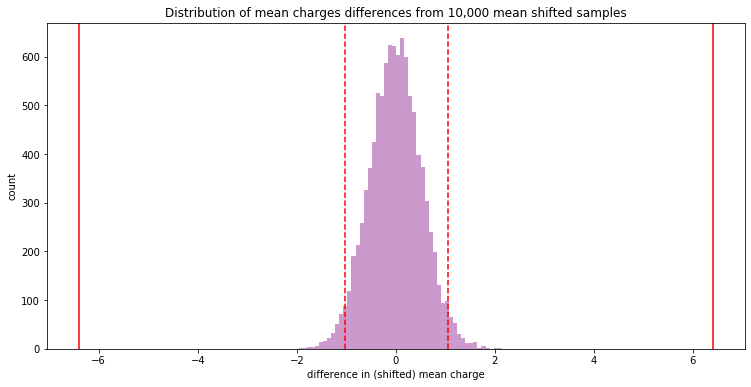

In [9]:
lower_percentile, upper_percentile = np.percentile(bs_replicates, [2.5,97.5])

#_ = plt.hist(bs_replicates, bins=20)
_ = sns.distplot(bs_replicates, kde=False, color ='purple')
_ = plt.xlabel('difference in (shifted) mean charge')
_ = plt.ylabel('count')
_ = plt.title('Distribution of mean charges differences from 10,000 mean shifted samples')
_ = plt.axvline(observed_mean_difference, color='r', linestyle='-')
_ = plt.axvline(-observed_mean_difference, color='r', linestyle='-')
_ = plt.axvline(lower_percentile, color='r', linestyle='--')
_ = plt.axvline(upper_percentile, color='r', linestyle='--')

### Bootstrapping to determine if the standard deviation of the net charge of nuclear proteins is statistically significant

In [10]:
obs_std_differences = np.std(nuclear_charge) - np.std(non_nuclear_charge)

nucleus_bs = draw_bs_reps(nuclear_charge, np.std, size=N_rep)
non_nuclear_bs = draw_bs_reps(non_nuclear_charge, np.std, size=N_rep)

std_differences = nucleus_bs - non_nuclear_bs

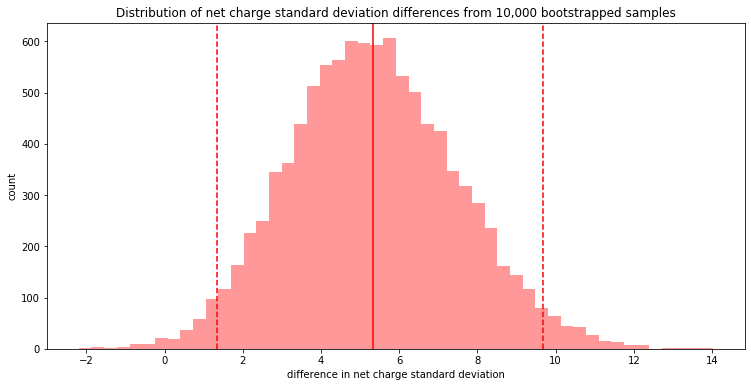

In [11]:
lower_percentile, upper_percentile = np.percentile(std_differences, [2.5,97.5])

#_ = plt.hist(std_differences, bins=30)
_ = sns.distplot(std_differences, kde=False, color ='red')
_ = plt.xlabel('difference in net charge standard deviation')
_ = plt.ylabel('count')
_ = plt.title('Distribution of net charge standard deviation differences from 10,000 bootstrapped samples')
_ = plt.axvline(np.mean(std_differences), color='r', linestyle='-')
_ = plt.axvline(lower_percentile, color='r', linestyle='--')
_ = plt.axvline(upper_percentile, color='r', linestyle='--')

In [12]:
p_val = np.sum(bs_replicates >= observed_mean_difference) / len(bs_replicates)
print('P-value (Standard): ', p_val)

n0 = len(nuclear_charge)
s0 = np.std(nuclear_charge, ddof=1)
x0 = np.mean(nuclear_charge)

s1 = np.std(non_nuclear_charge, ddof=1)
n1 = len(non_nuclear_charge)
x1 = np.mean(non_nuclear_charge)

from scipy.stats import ttest_ind_from_stats

t_stats, p_stats = ttest_ind_from_stats(x0,s0,n0,x1,s1,n1,equal_var=False)

#print('T critical value: ', t_stats)
print('P-value (Welch\'s): ', p_stats)

P-value (Standard):  0.0
P-value (Welch's):  1.2539644053488937e-33


__The low p-value (both standard and with assumed unequal variance between groups) suggests that we can say with confidence that nuclear proteins have a higher net charge.__

## Length of Peptide Sequence

The length of a peptide sequence was calculated by adding all of the individual amino acids present in a peptide sequence. Proteins localized to the cytoskeleton and cytoplasm appear to be longer on average.

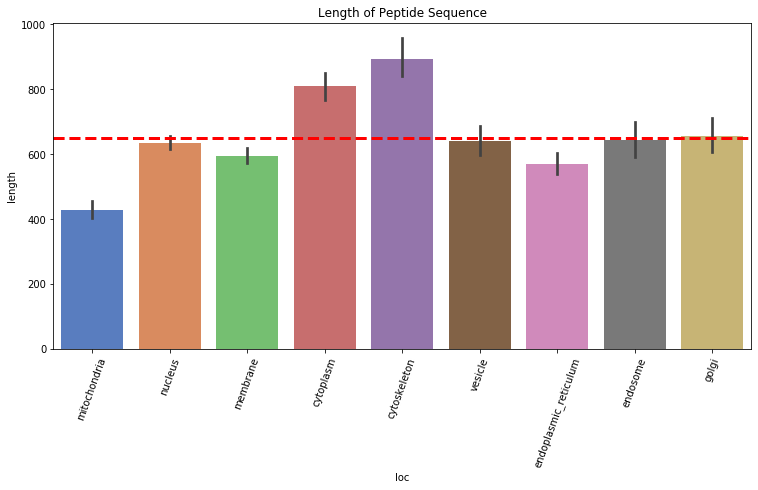

In [13]:
_ = sns.barplot(x='loc', y='length', data=df)
_ = plt.xticks(rotation=70)
_ = plt.axhline(y=np.mean(df.length), color='red', linestyle='--', lw=3)
_ = plt.title('Length of Peptide Sequence')

### Visualization of data to determine distribution

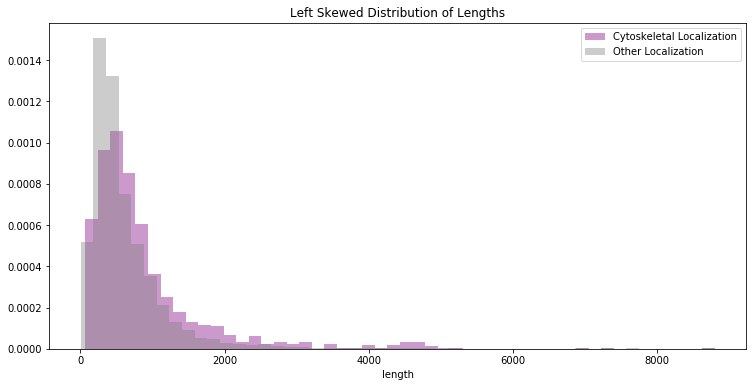

In [14]:
# To compare the nucleus associated proteins with the rest, a new subset of data is created containing all peptides not associated with the nucleus.
cytosk = df[df['loc'] == 'cytoskeleton']
non_cytosk = df[df['loc'] != 'cytoskeleton']

cyto_length = cytosk.length
non_cyto_length = non_cytosk.length

_ = sns.distplot(cyto_length, kde=False, norm_hist=True, label='Cytoskeletal Localization', color ='purple')
_ = sns.distplot(non_cyto_length, kde=False, norm_hist=True, label='Other Localization', color ='gray')
_ = plt.legend()
_ = plt.title('Left Skewed Distribution of Lengths')

### Bootstrapping to determine if the observed difference in peptide length of cytoskeletal proteins is statistically significant

In [15]:
observed_mean_difference = np.mean(cyto_length) - np.mean(non_cyto_length)
mean_length = np.mean(np.concatenate((cyto_length,non_cyto_length)))

cyto_shifted = cyto_length - np.mean(cyto_length) + mean_length
non_cyto_shifted = non_cyto_length - np.mean(non_cyto_length) + mean_length

In [16]:
cyto_bs_shifted = draw_bs_reps(cyto_shifted, np.mean, size=N_rep)
non_cyto_bs_shifted = draw_bs_reps(non_cyto_shifted, np.mean, size=N_rep)

bs_replicates = cyto_bs_shifted - non_cyto_bs_shifted

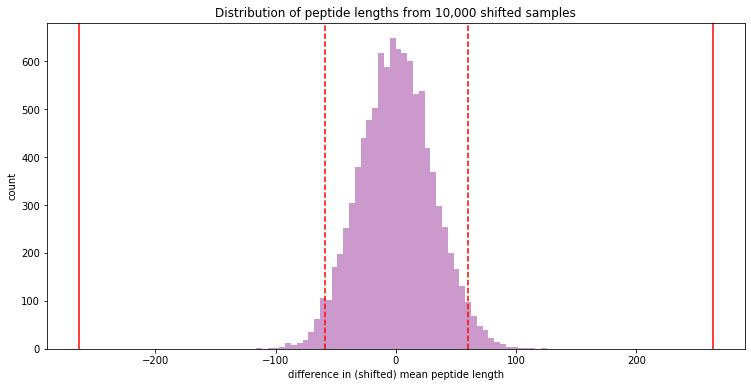

In [17]:
lower_percentile, upper_percentile = np.percentile(bs_replicates, [2.5,97.5])

#_ = plt.hist(bs_replicates, bins=20)
_ = sns.distplot(bs_replicates, kde=False, color ='purple')
_ = plt.xlabel('difference in (shifted) mean peptide length')
_ = plt.ylabel('count')
_ = plt.title('Distribution of peptide lengths from 10,000 shifted samples')
_ = plt.axvline(observed_mean_difference, color='r', linestyle='-')
_ = plt.axvline(-observed_mean_difference, color='r', linestyle='-')
_ = plt.axvline(lower_percentile, color='r', linestyle='--')
_ = plt.axvline(upper_percentile, color='r', linestyle='--')

In [18]:
p_val = np.sum(bs_replicates >= observed_mean_difference) / len(bs_replicates)
print('P-value (Standard): ', p_val)

n0 = len(cyto_length)
s0 = np.std(cyto_length, ddof=1)
x0 = np.mean(cyto_length)

s1 = np.std(non_cyto_length, ddof=1)
n1 = len(non_cyto_length)
x1 = np.mean(non_cyto_length)

from scipy.stats import ttest_ind_from_stats

t_stats, p_stats = ttest_ind_from_stats(x0,s0,n0,x1,s1,n1,equal_var=False)

#print('T critical value: ', t_stats)
print('P-value (Welch\'s): ', p_stats)

P-value (Standard):  0.0
P-value (Welch's):  2.4106148580737353e-17


__Again, bootstrapping demonstrates that there is a significant relationship between the length of a peptide and cytoskeletal localization.__

## Polarity Ratio

The polarity ratio is the number of polar amino acids present in a peptide sequence in relation to the total number of amino acids present. A high polarity ratio is likely indicative of a more polar protein. High polarity ratios are observed in mitochondrially associated proteins while lower polarity ratios are observed in cytoskeletal proteins. 

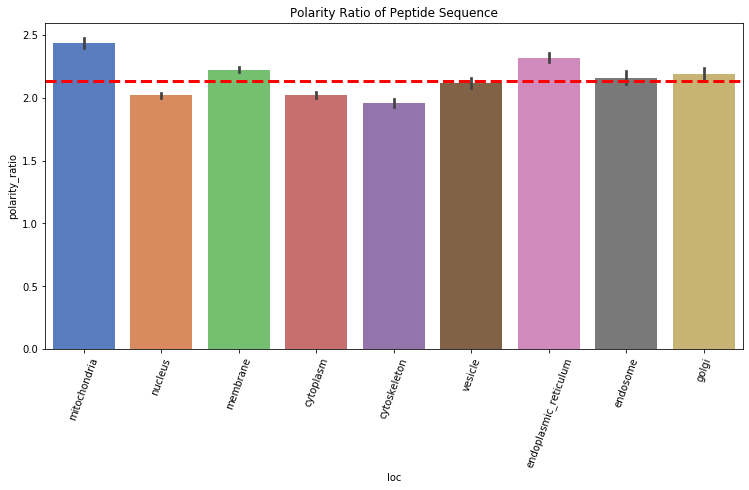

In [19]:
_ = sns.barplot(x='loc', y='polarity_ratio', data=df)
_ = plt.xticks(rotation=70)
_ = plt.axhline(y=np.mean(df.polarity_ratio), color='red', linestyle='--', lw=3)
_ = plt.title('Polarity Ratio of Peptide Sequence')

### Visualization of data to determine distribution

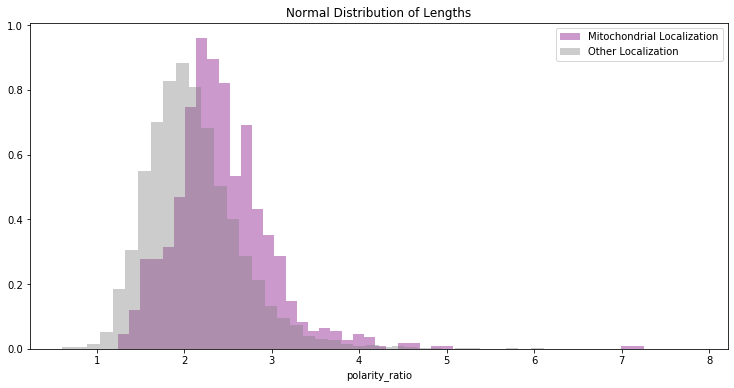

In [20]:
mito = df[df['loc'] == 'mitochondria']
non_mito = df[df['loc'] != 'mitochondria']

mito_ratio = mito.polarity_ratio
non_mito_ratio = non_mito.polarity_ratio

_ = sns.distplot(mito_ratio, kde=False, norm_hist=True, label='Mitochondrial Localization', color ='purple')
_ = sns.distplot(non_mito_ratio, kde=False, norm_hist=True, label='Other Localization', color ='gray')
_ = plt.legend()
_ = plt.title('Normal Distribution of Lengths')

### Bootstrapping to determine if the observed difference in the polarity ratio of mitochondrial proteins is statistically significant

In [21]:
observed_mean_difference = np.mean(mito_ratio) - np.mean(non_mito_ratio)
mean_length = np.mean(np.concatenate((mito_ratio,non_mito_ratio)))

mito_shifted = mito_ratio - np.mean(mito_ratio) + mean_length
non_mito_shifted = non_mito_ratio - np.mean(non_mito_ratio) + mean_length

bs_replicates

array([  6.64908562, -35.31910626,  49.15208836, ...,  17.08112859,
        14.49945087,   4.61896044])

In [22]:
mito_bs_shifted = draw_bs_reps(mito_shifted, np.mean, size=N_rep)
non_mito_bs_shifted = draw_bs_reps(non_mito_shifted, np.mean, size=N_rep)

bs_replicates = mito_bs_shifted - non_mito_bs_shifted

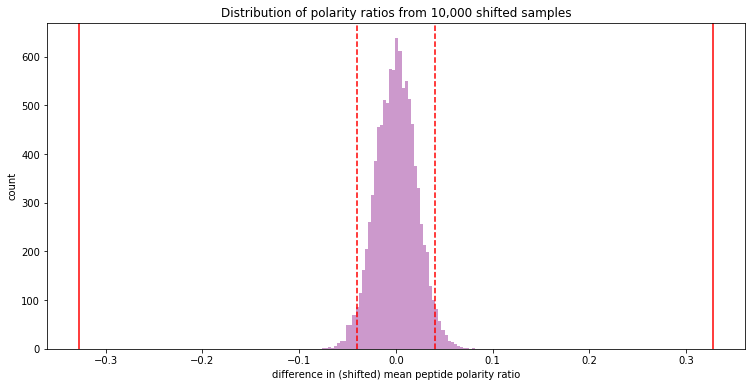

In [23]:
lower_percentile, upper_percentile = np.percentile(bs_replicates, [2.5,97.5])

#_ = plt.hist(bs_replicates, bins=20)
_ = sns.distplot(bs_replicates, kde=False, color ='purple')
_ = plt.xlabel('difference in (shifted) mean peptide polarity ratio')
_ = plt.ylabel('count')
_ = plt.title('Distribution of polarity ratios from 10,000 shifted samples')
_ = plt.axvline(observed_mean_difference, color='r', linestyle='-')
_ = plt.axvline(-observed_mean_difference, color='r', linestyle='-')
_ = plt.axvline(lower_percentile, color='r', linestyle='--')
_ = plt.axvline(upper_percentile, color='r', linestyle='--')

In [24]:
p_val = np.sum(bs_replicates >= observed_mean_difference) / len(bs_replicates)
print('P-value (Standard): ', p_val)

n0 = len(mito_ratio)
s0 = np.std(mito_ratio, ddof=1)
x0 = np.mean(mito_ratio)

s1 = np.std(non_mito_ratio, ddof=1)
n1 = len(non_mito_ratio)
x1 = np.mean(non_mito_ratio)

from scipy.stats import ttest_ind_from_stats

t_stats, p_stats = ttest_ind_from_stats(x0,s0,n0,x1,s1,n1,equal_var=False)

#print('T critical value: ', t_stats)
print('P-value (Welch\'s): ', p_stats)

P-value (Standard):  0.0
P-value (Welch's):  5.519567213250864e-50


__The polarity ratio of a peptide is likely predictive of whether a protein will localize to mitochondria.__

# Correlations between variables

## Peptide size parameters

### Length

In [25]:
peptide_info = ['length','mass','PTM','STRUCTURAL','BINDING','CHAIN','CARBOHYD','CROSSLNK','DISULFID','LIPID','METAL','TRANSMEM','positive_aa','negative_aa','nonpolar_aa','polar_aa','positive_ratio','negative_ratio','polarity_ratio','net_charge']

mito_correlation = mitochondria[peptide_info].corr(method='pearson').length
correlations = pd.DataFrame({str(mitochondria['loc'][-1:].values[0]):mito_correlation})

for location in localizations:
    correlation = location[peptide_info].corr(method='pearson').length
    localization = location['loc'][-1:].values[0]
    corr_df = pd.DataFrame({localization:correlation})
    correlations = correlations.merge(corr_df,left_index=True, right_index=True)
    
correlations = correlations.drop('mitochondria_y', axis=1)
correlations[(correlations > 0.25) | (correlations < -0.25)]

,mitochondria_x,cytoskeleton,cytoplasm,endoplasmic_reticulum,endosome,golgi,membrane,nucleus,vesicle
length,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mass,0.999467,0.999396,0.999415,0.999461,0.999600,0.999542,0.999397,0.999204,0.999302
PTM,0.302931,0.309334,0.322744,0.419338,0.550754,0.460173,0.547191,0.348810,0.474266
STRUCTURAL,0.294320,NaN,NaN,NaN,NaN,NaN,0.291438,NaN,NaN
BINDING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CARBOHYD,NaN,NaN,NaN,0.347208,0.416146,0.318570,0.476122,NaN,NaN
CROSSLNK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISULFID,NaN,NaN,NaN,NaN,0.428414,NaN,0.356325,NaN,NaN
LIPID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Mass

In [26]:
mito_correlation = mitochondria[peptide_info].corr(method='pearson').mass
correlations = pd.DataFrame({str(mitochondria['loc'][-1:].values[0]):mito_correlation})

for location in localizations:
    correlation = location[peptide_info].corr(method='pearson').mass
    localization = location['loc'][-1:].values[0]
    corr_df = pd.DataFrame({localization:correlation})
    correlations = correlations.merge(corr_df,left_index=True, right_index=True)
    
correlations = correlations.drop('mitochondria_y', axis=1)
correlations[(correlations > 0.25) | (correlations < -0.25)]

,mitochondria_x,cytoskeleton,cytoplasm,endoplasmic_reticulum,endosome,golgi,membrane,nucleus,vesicle
length,0.999467,0.999396,0.999415,0.999461,0.999600,0.999542,0.999397,0.999204,0.999302
mass,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PTM,0.293118,0.298965,0.313206,0.412287,0.550536,0.453057,0.542127,0.343309,0.470493
STRUCTURAL,0.288252,NaN,NaN,NaN,NaN,NaN,0.296025,NaN,NaN
BINDING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CARBOHYD,NaN,NaN,NaN,0.339987,0.416789,0.310782,0.470796,NaN,NaN
CROSSLNK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISULFID,NaN,NaN,NaN,NaN,0.430217,NaN,0.350589,NaN,NaN
LIPID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Correlations between non-normalized variables like length and mass are not very informative, as all of these variables strongly correlate with the total number of features present in a peptide.

## Ratiometric Parameters

### Net charge

In [27]:
mito_correlation = mitochondria[peptide_info].corr(method='pearson').net_charge
correlations = pd.DataFrame({str(mitochondria['loc'][-1:].values[0]):mito_correlation})

for location in localizations:
    correlation = location[peptide_info].corr(method='pearson').net_charge
    localization = location['loc'][-1:].values[0]
    corr_df = pd.DataFrame({localization:correlation})
    correlations = correlations.merge(corr_df,left_index=True, right_index=True)
    
correlations = correlations.drop('mitochondria_y', axis=1)
correlations[(correlations > 0.25) | (correlations < -0.25)]

,mitochondria_x,cytoskeleton,cytoplasm,endoplasmic_reticulum,endosome,golgi,membrane,nucleus,vesicle
length,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PTM,NaN,NaN,NaN,NaN,-0.258112,NaN,NaN,NaN,NaN
STRUCTURAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BINDING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CARBOHYD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CROSSLNK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISULFID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LIPID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A slight negative correlation is observed between net charge and number of post-translational modifications (PTM) only in endosome-localizing proteins. This implies that endosomal proteins with higher net charges may recieve fewer modifications.

### Positive ratio

In [28]:
mito_correlation = mitochondria[peptide_info].corr(method='pearson').positive_ratio
correlations = pd.DataFrame({str(mitochondria['loc'][-1:].values[0]):mito_correlation})

for location in localizations:
    correlation = location[peptide_info].corr(method='pearson').positive_ratio
    localization = location['loc'][-1:].values[0]
    corr_df = pd.DataFrame({localization:correlation})
    correlations = correlations.merge(corr_df,left_index=True, right_index=True)
    
correlations = correlations.drop('mitochondria_y', axis=1)
correlations[(correlations > 0.25) | (correlations < -0.25)]

,mitochondria_x,cytoskeleton,cytoplasm,endoplasmic_reticulum,endosome,golgi,membrane,nucleus,vesicle
length,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STRUCTURAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BINDING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CARBOHYD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CROSSLNK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISULFID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LIPID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Negative ratio

In [29]:
mito_correlation = mitochondria[peptide_info].corr(method='pearson').negative_ratio
correlations = pd.DataFrame({str(mitochondria['loc'][-1:].values[0]):mito_correlation})

for location in localizations:
    correlation = location[peptide_info].corr(method='pearson').negative_ratio
    localization = location['loc'][-1:].values[0]
    corr_df = pd.DataFrame({localization:correlation})
    correlations = correlations.merge(corr_df,left_index=True, right_index=True)
    
correlations = correlations.drop('mitochondria_y', axis=1)
correlations[(correlations > 0.25) | (correlations < -0.25)]

,mitochondria_x,cytoskeleton,cytoplasm,endoplasmic_reticulum,endosome,golgi,membrane,nucleus,vesicle
length,NaN,NaN,NaN,NaN,NaN,NaN,0.287947,NaN,NaN
mass,NaN,NaN,NaN,NaN,NaN,NaN,0.292485,NaN,NaN
PTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STRUCTURAL,NaN,NaN,NaN,NaN,NaN,NaN,0.271005,NaN,NaN
BINDING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CARBOHYD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CROSSLNK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISULFID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LIPID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Moderate negative correlations are observed between the number of charged amino acids per peptide sequence and the number of transmembrane domains observed. This is likely because charged amino acids are less able to integrate into proteins, so a higher proportion of them in a peptide sequence will be negatively associated with transmembrane regions.

### Polarity ratio

In [30]:
mito_correlation = mitochondria[peptide_info].corr(method='pearson').polarity_ratio
correlations = pd.DataFrame({str(mitochondria['loc'][-1:].values[0]):mito_correlation})

for location in localizations:
    correlation = location[peptide_info].corr(method='pearson').polarity_ratio
    localization = location['loc'][-1:].values[0]
    corr_df = pd.DataFrame({localization:correlation})
    correlations = correlations.merge(corr_df,left_index=True, right_index=True)
    
correlations = correlations.drop('mitochondria_y', axis=1)
correlations[(correlations > 0.25) | (correlations < -0.25)]

,mitochondria_x,cytoskeleton,cytoplasm,endoplasmic_reticulum,endosome,golgi,membrane,nucleus,vesicle
length,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STRUCTURAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BINDING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHAIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CARBOHYD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CROSSLNK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISULFID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LIPID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A moderate positive correlation was observed with the polarity ratio of a sequence and the number of transmembrane regions observed as well. This is likely because polar amino acids integrate better into membranes.

# Conclusions

Numerous variables have been identified that are predictive of particular subcellular localizations in cells. These analyses likely only contain a sample of the useful relationships that are found in these data due to the high number of features. This fact makes these data a good candidate for analysis through machine learning algorithms.